#1. Import Libraries

In [ ]:
pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.express as px
import cv2
from PIL import Image
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel


plt.style.use("seaborn")
plt.rcParams['figure.figsize'] = (13, 7)

<ipython-input-212-1a4cf269b0e0>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


#2. Load Data

In [ ]:
id_df = pd.read_csv("/content/drive/MyDrive/DataMining/BTL/data/book_id.csv")
data_df = pd.read_csv("/content/drive/MyDrive/DataMining/BTL/data/book_data.csv")
cmt_df = pd.read_csv("/content/drive/MyDrive/DataMining/BTL/data/comments.csv")

In [ ]:
data_df.head(5)

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link
0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,108000,64800,53075.0,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...
1,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,108000,64800,53075.0,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...
2,184466860,Hành Tinh Của Một Kẻ Nghĩ Nhiều,Nguyễn Đoàn Minh Thư,86000,59900,7929.0,Sách tư duy - Kỹ năng sống,780,4.8,184,Nhà Xuất Bản Thế Giới,https://salt.tikicdn.com/ts/product/d7/99/24/1...
3,73787185,Những Tù Nhân Của Địa Lý,Tim Marshall,210000,126000,17896.0,Lĩnh vực khác,3623,4.8,430,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/8d/96/9e/c...
4,52789367,Nhà Giả Kim (Tái Bản 2020),Paulo Coelho,79000,47400,24668.0,Tác phẩm kinh điển,5131,5.0,228,Nhà Xuất Bản Hà Nội,https://salt.tikicdn.com/ts/product/45/3b/fc/a...


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      1796 non-null   int64  
 1   title           1796 non-null   object 
 2   authors         1653 non-null   object 
 3   original_price  1796 non-null   int64  
 4   current_price   1796 non-null   int64  
 5   quantity        1751 non-null   float64
 6   category        1796 non-null   object 
 7   n_review        1796 non-null   int64  
 8   avg_rating      1796 non-null   float64
 9   pages           1546 non-null   object 
 10  manufacturer    1523 non-null   object 
 11  cover_link      1796 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 168.5+ KB


In [ ]:
id_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      2024 non-null   int64
dtypes: int64(1)
memory usage: 15.9 KB


#3. Data Preparation

##3.1 Handle Value and Missing Data

In [ ]:
data_df.isnull().sum()

product_id          0
title               0
authors           143
original_price      0
current_price       0
quantity           45
category            0
n_review            0
avg_rating          0
pages             250
manufacturer      273
cover_link          0
dtype: int64

###Title

*Remove* duplicated titles

In [ ]:
data_df = data_df.drop_duplicates(subset=['title'])

###Author

In [ ]:
data_df.authors.value_counts()

Nguyễn Nhật Ánh    24
Higashino Keigo    20
.                  18
Thích Nhất Hạnh    16
Haruki Murakami    15
                   ..
Urako Kanamori      1
Cổ Viên             1
Robert Winston      1
Yongchul Kwon       1
John C. Maxwell     1
Name: authors, Length: 1083, dtype: int64

Thay "." thành "Unknown"

In [ ]:
data_df.loc[data_df.authors == '.' , 'authors'] = "Unknown"

thay giá trị null thành "Unknown"

In [ ]:
data_df.authors = data_df.authors.fillna("Unknown")

<ipython-input-221-17ffc69ff0df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.authors = data_df.authors.fillna("Unknown")


In [ ]:
data_df.authors.value_counts()

Unknown            156
Nguyễn Nhật Ánh     24
Higashino Keigo     20
Thích Nhất Hạnh     16
Haruki Murakami     15
                  ... 
Urako Kanamori       1
Cổ Viên              1
Robert Winston       1
Yongchul Kwon        1
John C. Maxwell      1
Name: authors, Length: 1083, dtype: int64

###Quantity

In [ ]:
data_df.quantity = data_df.quantity.fillna(np.mean(data_df.quantity))

<ipython-input-223-1a96270bfba1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.quantity = data_df.quantity.fillna(np.mean(data_df.quantity))


###Category

In [ ]:
data_df.category.value_counts()

Sách tư duy - Kỹ năng sống                 292
Tiểu Thuyết                                133
Truyện ngắn - Tản văn - Tạp Văn            109
Sách nghệ thuật sống đẹp                    58
Sách kỹ năng làm việc                       55
                                          ... 
Shaman King - Tập 19                         1
Blue Period - Tập 07                         1
Komi - Nữ Thần Sợ Giao Tiếp - Tập 14         1
Bên Rặng Tuyết Sơn (Tái Bản)                 1
Kaguya-Sama: Cuộc Chiến Tỏ Tình - Tập 3      1
Name: category, Length: 354, dtype: int64

Thay "Kiến Thức Bách Khoa" thành "Kiến thức - Bách khoa"

In [ ]:
data_df.loc[data_df.category == 'Kiến Thức Bách Khoa' , 'category'] = "Kiến thức - Bách khoa"

Lấy ra danh sách 30 thể loại đầu tiên

In [ ]:
keeping_values = list(pd.DataFrame(data_df.category.value_counts()[1:30]).T.columns)
keeping_values

['Tiểu Thuyết',
 'Truyện ngắn - Tản văn - Tạp Văn',
 'Sách nghệ thuật sống đẹp',
 'Kiến thức - Bách khoa',
 'Sách kỹ năng làm việc',
 'Bài học kinh doanh',
 'Truyện trinh thám',
 'Sách Học Tiếng Anh',
 'Sách Marketing - Bán hàng ',
 'Sách tài chính, tiền tệ',
 'Tác phẩm kinh điển',
 'Truyện Giả tưởng - Huyền Bí - Phiêu Lưu',
 'Sách Làm Cha Mẹ',
 'Lĩnh vực khác',
 'Truyện dài',
 'Văn học thiếu nhi',
 'Light novel',
 'Truyện đam mỹ',
 'Truyện kể cho bé',
 'Sách quản trị, lãnh đạo',
 'Tiểu sử - Hồi ký',
 'Lịch Sử Thế Giới',
 'Sách Học Tiếng Hoa',
 'Truyện tranh Ehon',
 'Sách Chiêm Tinh - Horoscope',
 'Sách giáo dục',
 'Sách kinh tế học',
 'Tô màu - Luyện chữ  ',
 'Thơ']

Thay giá trị của các thể loại ngoài danh sách 30 thể loại đầu tiên thành "Others"

In [ ]:
def handle_category(category):
    if category not in keeping_values:
        return "Others"
    return category

data_df.category = data_df.category.apply(lambda category: handle_category(category))

<ipython-input-227-bed053b71b76>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.category = data_df.category.apply(lambda category: handle_category(category))


###Pages

In [ ]:
def handle_pages(lst_pages):
    lst_int = []
    for page in lst_pages:
        try:
            lst_int.append(int(page))
        except:
            continue

    return np.mean(lst_int)

mean_pages = handle_pages(list(data_df.pages))

In [ ]:
data_df.pages = data_df.pages.fillna(str(mean_pages))

In [ ]:
data_df.query('pages == "Cuốn"')

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link
1266,197639028,Động Từ Bất Quy Tắc Và Ngữ Pháp Tiếng Anh Căn Bản,Mai Lan Hương,18000,12000,136.0,Sách Học Tiếng Anh,2,5.0,Cuốn,Nhà Xuất Bản Đà Nẵng,https://salt.tikicdn.com/ts/product/28/8e/9e/0...


In [ ]:
data_df = data_df.query('pages != "Cuốn"')

Thay đổi kiểu dữ liệu

In [ ]:
data_df.pages = data_df.pages.apply(lambda page: round(float(page)))
data_df.pages = data_df.pages.astype("int64")

<ipython-input-232-ea51b01eedfa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.pages = data_df.pages.apply(lambda page: round(float(page)))
<ipython-input-232-ea51b01eedfa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.pages = data_df.pages.astype("int64")


In [ ]:
data_df.pages.describe()

count      1768.000000
mean        455.603507
std        4561.569635
min          10.000000
25%         220.000000
50%         332.000000
75%         456.000000
max      192000.000000
Name: pages, dtype: float64

In [ ]:
data_df[data_df.pages > 3000]

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link
650,201687274,Có Một Nổi Buồn Vừa Ngang Qua Đây,Gã,88000,64900,114.0,Truyện ngắn - Tản văn - Tạp Văn,6,5.0,192000,Nhà Xuất Bản Văn Học,https://salt.tikicdn.com/ts/product/08/fd/a5/0...


Loại bỏ những cuốn sách có từ 3000 trang trở lên

In [ ]:
data_df = data_df.query('pages < 3000')

###Manufacturer

In [ ]:
data_df.manufacturer.value_counts()

Nhà Xuất Bản Thế Giới                            247
NXB Trẻ                                          143
Nhà Xuất Bản Hà Nội                              128
Nhà Xuất Bản Dân Trí                             126
Nhà Xuất Bản Kim Đồng                            113
Nhà Xuất Bản Hội Nhà Văn                         111
Nhà Xuất Bản Thanh Niên                           97
Nhà Xuất Bản Tổng hợp TP.HCM                      91
Nhà Xuất Bản Lao Động                             89
Nhà Xuất Bản Văn Học                              76
Nhà Xuất Bản Hồng Đức                             56
Nhà Xuất Bản Công Thương                          46
Nhà Xuất Bản Phụ Nữ Việt Nam                      38
Nhà Xuất Bản Phụ Nữ                               30
Nhà Xuất Bản Đà Nẵng                              16
Nhà Xuất Bản Đại Học Quốc Gia Hà Nội              13
Nhà Xuất Bản Mỹ Thuật                              8
Nhà Xuất Bản Tri Thức                              7
Nhà Xuất Bản Lao Động Xã Hội                  

In [ ]:
def handle_manufactuner(manufactuner):
    if manufactuner == "hong duc":
        return "Nhà Xuất Bản Hồng Đức"
    elif manufactuner == "NXB Dân Trí":
        return "Nhà Xuất Bản Dân Trí"
    elif manufactuner == "ĐHQG Hà Nội":
        return "Nhà Xuất Bản Đại Học Quốc Gia Hà Nội"
    elif manufactuner == "NXB Trẻ":
        return "Nhà Xuất Bản Trẻ"
    elif manufactuner == "NXB Đại học Kinh Tế Quốc Dân":
        return "Nhà Xuất Bản Đại học Kinh Tế Quốc Dân"
    else:
        return manufactuner

data_df.manufacturer = data_df.manufacturer.apply(lambda manufacturer: handle_manufactuner(manufacturer))

In [ ]:
data_df.manufacturer = data_df.manufacturer.fillna("Unknown")

In [ ]:
data_df.manufacturer.value_counts()

Unknown                                          265
Nhà Xuất Bản Thế Giới                            247
Nhà Xuất Bản Trẻ                                 143
Nhà Xuất Bản Dân Trí                             132
Nhà Xuất Bản Hà Nội                              128
Nhà Xuất Bản Kim Đồng                            113
Nhà Xuất Bản Hội Nhà Văn                         111
Nhà Xuất Bản Thanh Niên                           97
Nhà Xuất Bản Tổng hợp TP.HCM                      91
Nhà Xuất Bản Lao Động                             89
Nhà Xuất Bản Văn Học                              76
Nhà Xuất Bản Hồng Đức                             59
Nhà Xuất Bản Công Thương                          46
Nhà Xuất Bản Phụ Nữ Việt Nam                      38
Nhà Xuất Bản Phụ Nữ                               30
Nhà Xuất Bản Đà Nẵng                              16
Nhà Xuất Bản Đại Học Quốc Gia Hà Nội              14
Nhà Xuất Bản Mỹ Thuật                              8
Nhà Xuất Bản Tri Thức                         

###Create new column "Discount"

In [ ]:
data_df['discount'] = round(1 - data_df['current_price']/data_df['original_price'],2)

###Thay đổi đơn vị tiền VND thành USD

In [ ]:
def convert_to_usd(vietnamdong):
    usd = vietnamdong/23700
    usd = round(usd, 2)

    return usd

data_df.original_price = data_df.original_price.apply(lambda vietnamdong: convert_to_usd(vietnamdong))
data_df.current_price = data_df.current_price.apply(lambda vietnamdong: convert_to_usd(vietnamdong))

##3.2 Change DataType


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1767 entries, 0 to 1795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      1767 non-null   int64  
 1   title           1767 non-null   object 
 2   authors         1767 non-null   object 
 3   original_price  1767 non-null   float64
 4   current_price   1767 non-null   float64
 5   quantity        1767 non-null   float64
 6   category        1767 non-null   object 
 7   n_review        1767 non-null   int64  
 8   avg_rating      1767 non-null   float64
 9   pages           1767 non-null   int64  
 10  manufacturer    1767 non-null   object 
 11  cover_link      1767 non-null   object 
 12  discount        1766 non-null   float64
dtypes: float64(5), int64(3), object(5)
memory usage: 193.3+ KB


In [ ]:
data_df.title = data_df.title.astype("string")
data_df.authors = data_df.authors.astype("string")
data_df.category = data_df.category.astype("string")
data_df.manufacturer = data_df.manufacturer.astype("string")
data_df.cover_link = data_df.cover_link.astype("string")

data_df.quantity = data_df.quantity.apply(lambda quantity: round(float(quantity)))
data_df.quantity = data_df.quantity.astype("int64")

#4. Exploratory Data Analysis (EDA)

In [ ]:
data_df.head(1)

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link,discount
0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,4.56,2.73,53075,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...,0.4


Tạo df mới để dễ trực quan hóa hơn

In [ ]:
eda_df = data_df.drop(['product_id', 'cover_link'], axis=1)
eda_df.authors.value_counts()

Unknown            156
Nguyễn Nhật Ánh     24
Higashino Keigo     20
Thích Nhất Hạnh     16
Haruki Murakami     15
                  ... 
Pauline Réage        1
@yenlamtho           1
Thân Tử Thần         1
Dave Trott           1
John C. Maxwell      1
Name: authors, Length: 1082, dtype: Int64

##4.1 Data Overviewing

### Price
* original_price
* current_price

<ipython-input-246-bce33aae70b6>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(eda_df.original_price, color='gray', shade=True, label='Original')
<ipython-input-246-bce33aae70b6>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(eda_df.current_price, color='g', shade=True, label='Current')


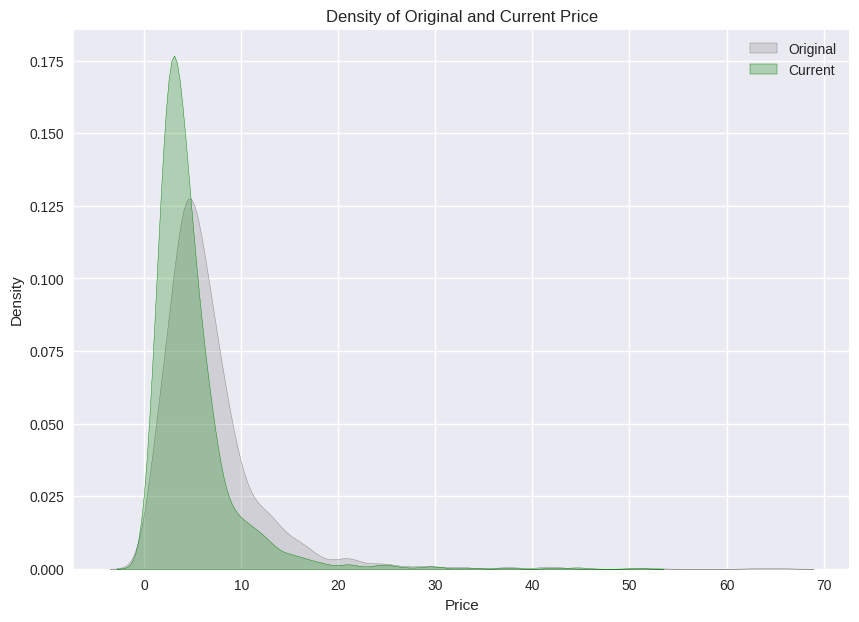

In [ ]:
fig = plt.subplots(figsize=(10, 7))

ax = sns.kdeplot(eda_df.original_price, color='gray', shade=True, label='Original')
ax = sns.kdeplot(eda_df.current_price, color='g', shade=True, label='Current')

plt.xlabel('Price')
plt.title('Density of Original and Current Price')
plt.legend()
plt.show()

Nhìn vào biểu đồ ta có thể thấy đa số sách sẽ có giá từ **20$** trở xuống. Có thể kết luận giá sách ở Việt Nam là quá rẻ.

###Discount per Category

In [ ]:
eda_df.groupby('category').discount.mean()

category
Bài học kinh doanh                         0.263962
Kiến thức - Bách khoa                      0.309821
Light novel                                0.250000
Lĩnh vực khác                              0.316774
Lịch Sử Thế Giới                           0.314286
Others                                     0.230636
Sách Chiêm Tinh - Horoscope                0.259286
Sách Học Tiếng Anh                         0.310750
Sách Học Tiếng Hoa                         0.182857
Sách Làm Cha Mẹ                            0.308125
Sách Marketing - Bán hàng                  0.254500
Sách giáo dục                              0.291538
Sách kinh tế học                           0.324615
Sách kỹ năng làm việc                      0.296364
Sách nghệ thuật sống đẹp                   0.281552
Sách quản trị, lãnh đạo                    0.286667
Sách tài chính, tiền tệ                    0.121750
Thơ                                        0.210000
Tiểu Thuyết                                0.353910
Tiể

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7873 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND GRAVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7885 (\N{LATIN SMALL LETTER O WITH DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7871 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 417 (\N{LATIN SMALL LETTER O WITH HORN}) mis

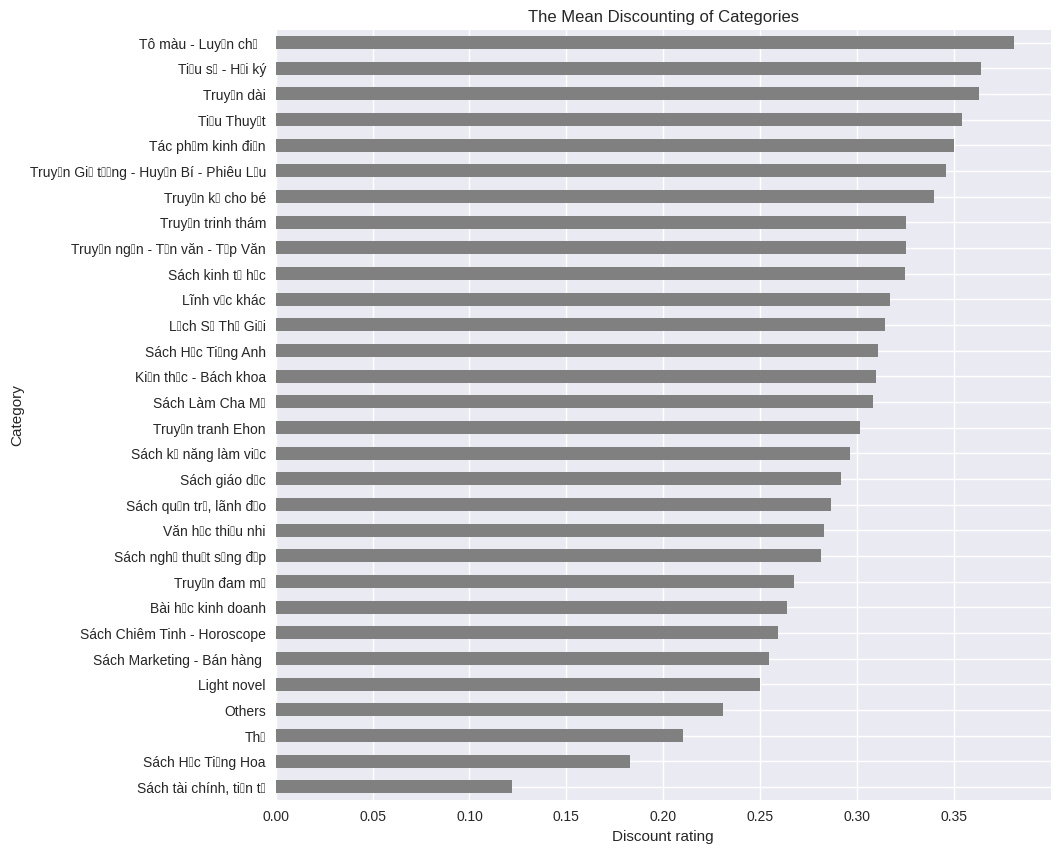

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax=eda_df.groupby('category').discount.mean().sort_values(ascending=True).plot(kind='barh', color='gray')

plt.xlabel('Discount rating')
plt.ylabel('Category')
plt.title('The Mean Discounting of Categories')
plt.show()

Hầu hết các danh mục giảm giá là truyện (chứa '**Truyen**')

###Quantity per Category All of Time

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 417 (\N{LATIN SMALL LETTER O WITH HORN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7909 (\N{LATIN SMALL LETTER U WITH DOT BELOW}) missing from current fon

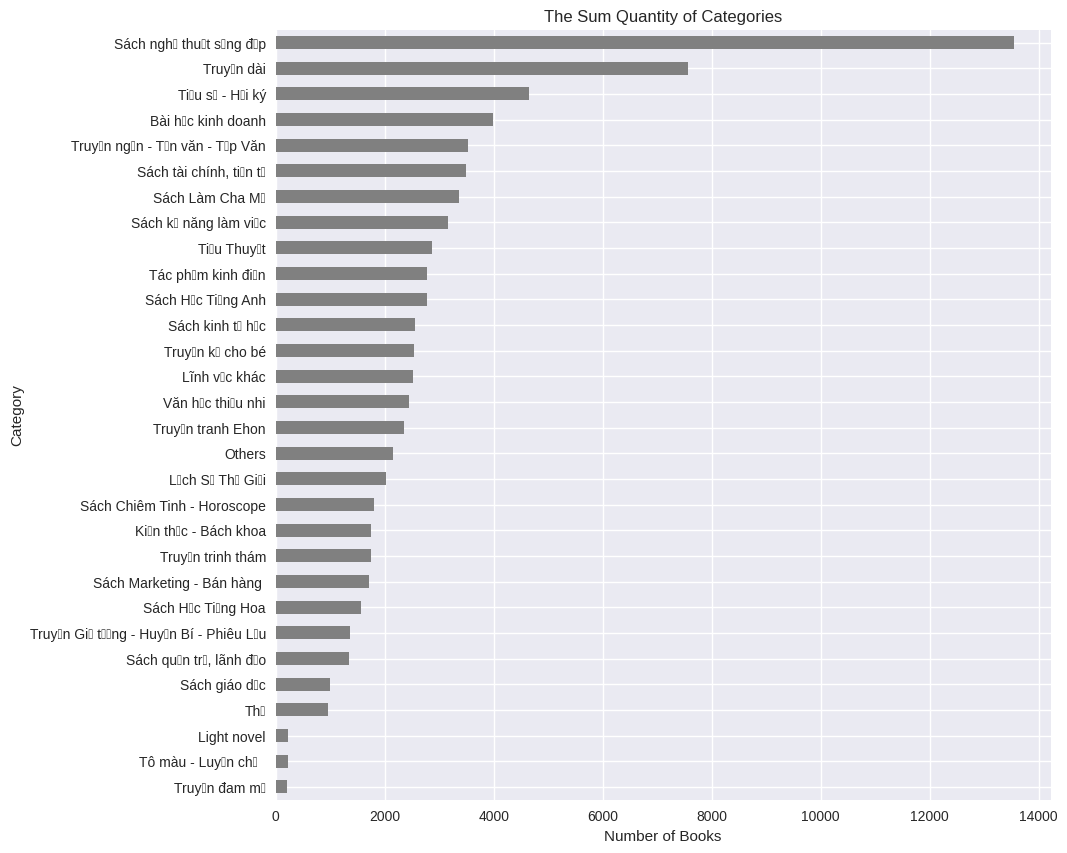

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax=eda_df.groupby('category').quantity.mean().sort_values(ascending=True).plot(kind='barh', color='gray')

plt.xlabel('Number of Books')
plt.ylabel('Category')
plt.title('The Sum Quantity of Categories')
plt.show()

###Rating per Category

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7921 (\N{LATIN SMALL LETTER U WITH HORN AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7885 (\N{LATIN SMALL LETTER O WITH DOT BELOW}) missing f

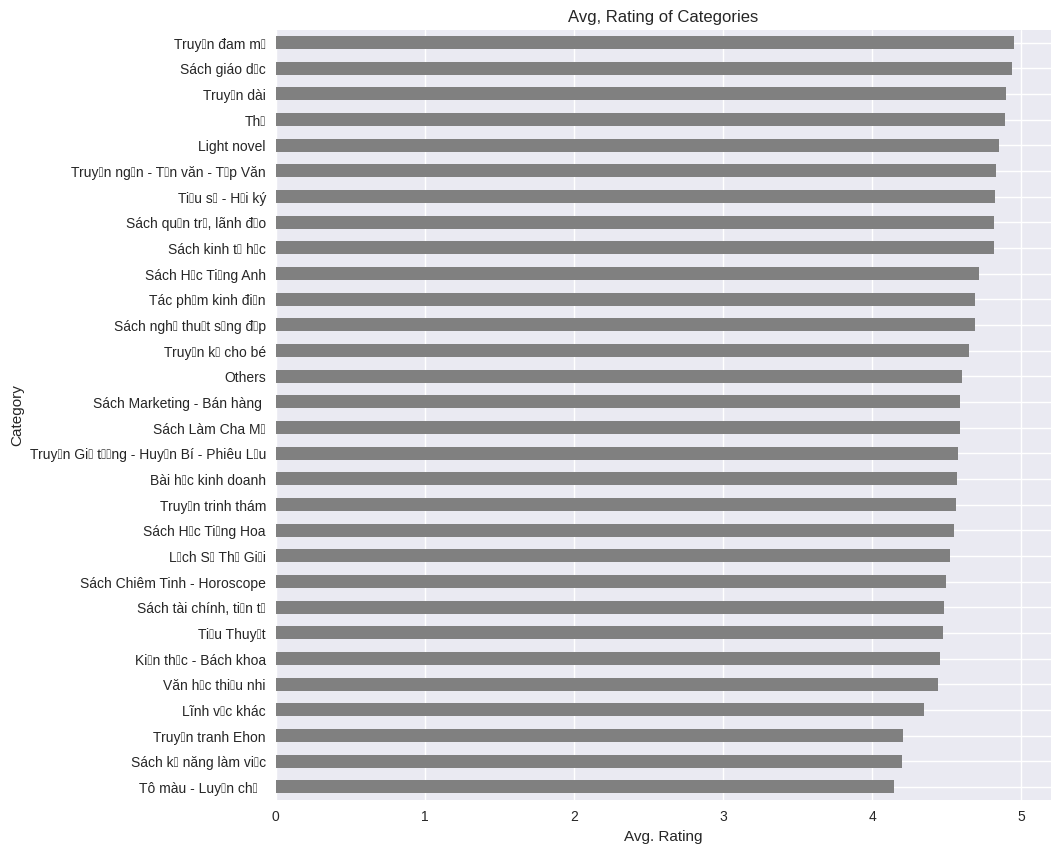

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax=eda_df.groupby('category').avg_rating.mean().sort_values(ascending=True).plot(kind='barh', color='gray')

plt.xlabel('Avg. Rating')
plt.ylabel('Category')
plt.title('Avg, Rating of Categories')
plt.show()

Tất cả thể loại đều có trung bình đánh giá trên 4

##4.2 EDA

In [ ]:
eda_df.describe()

,original_price,current_price,quantity,n_review,avg_rating,pages,discount
count,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1766.000000
mean,6.692586,4.861330,2805.490662,328.848896,4.596491,347.202603,0.272418
std,5.367041,4.298247,16796.190782,730.947525,1.129788,180.553555,0.135202
min,0.000000,0.000000,1.000000,0.000000,0.000000,10.000000,0.000000
25%,3.760000,2.530000,180.500000,16.000000,4.800000,220.000000,0.200000
50%,5.440000,3.750000,608.000000,75.000000,4.800000,332.000000,0.300000
75%,7.970000,5.760000,2376.000000,304.500000,5.000000,456.000000,0.370000
max,65.400000,50.630000,671121.000000,11481.000000,5.000000,2004.000000,0.800000


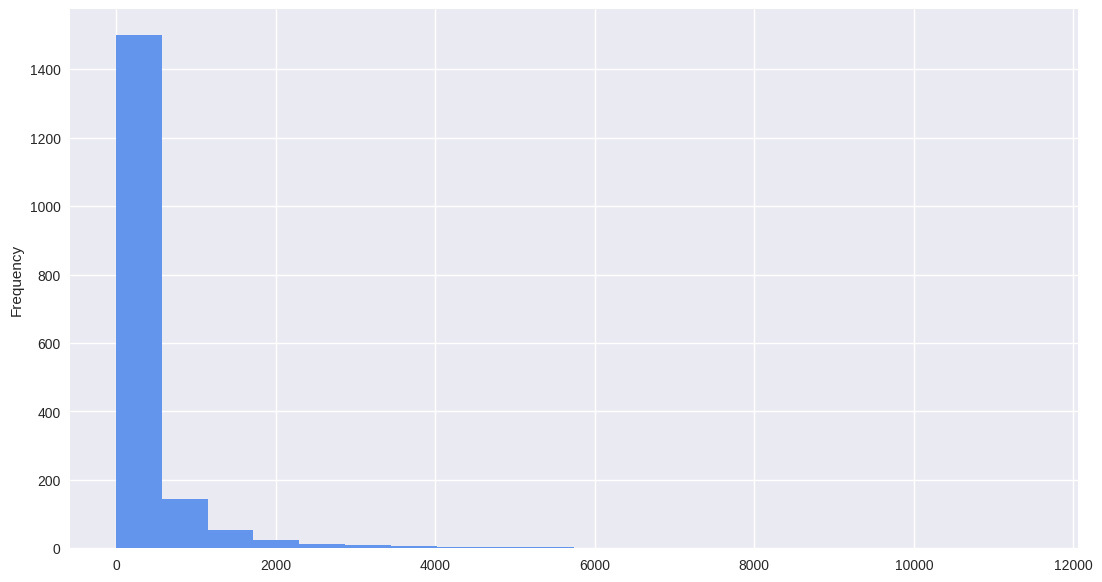

In [ ]:
eda_df.n_review.plot(kind='hist', bins=20, color='cornflowerblue');

In [ ]:
larger_3000_reviews_df = eda_df.query('n_review > 3000').reset_index(drop=True)

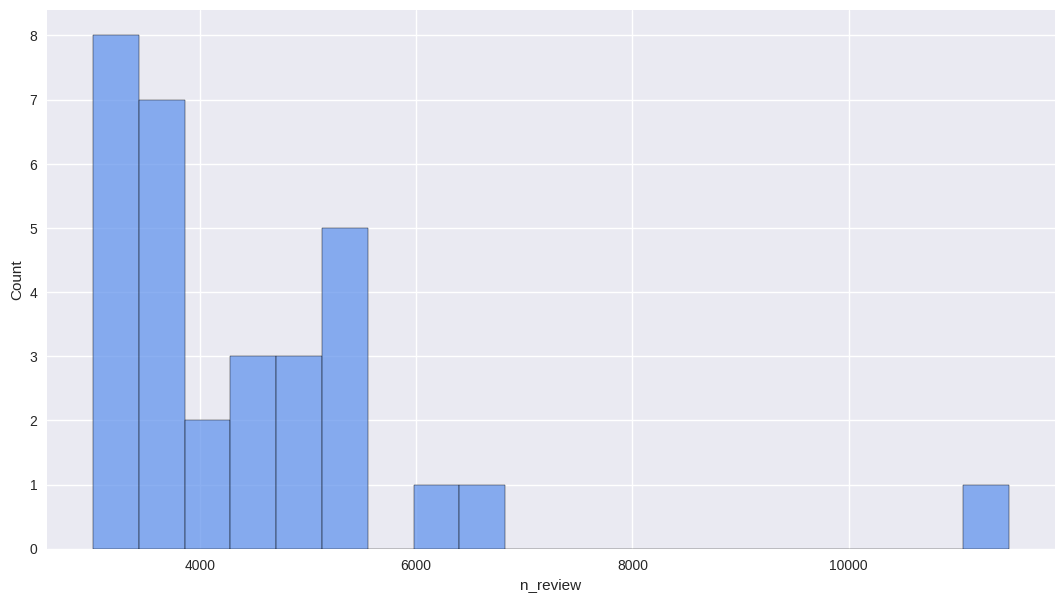

In [ ]:
sns.histplot(data=larger_3000_reviews_df.n_review, bins=20, color='cornflowerblue');

In [ ]:
larger_3000_reviews_df.query('n_review >= 6000').reset_index(drop=True)

,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,4.56,2.73,53075,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,0.40
1,Luật Tâm Thức - Giải Mã Ma Trận Vũ Trụ,Ngô Sa Thạch,13.50,9.41,27672,Lĩnh vực khác,6325,4.7,408,Nhà Xuất Bản Dân Trí,0.30
2,"Nóng Giận Là Bản Năng , Tĩnh Lặng Là Bản Lĩnh",Tống Mặc,3.76,2.41,65623,Others,6602,4.8,264,Unknown,0.36


####Top books have number of reviews larger than 3000.

Chỉ có 3 quyển sách có trên 6000 lượt đánh giá

In [ ]:
larger_3000_reviews_df

,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,4.56,2.73,53075,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,0.40
1,Những Tù Nhân Của Địa Lý,Tim Marshall,8.86,5.32,17896,Lĩnh vực khác,3623,4.8,430,Nhà Xuất Bản Hội Nhà Văn,0.40
2,Nhà Giả Kim (Tái Bản 2020),Paulo Coelho,3.33,2.00,24668,Tác phẩm kinh điển,5131,5.0,228,Nhà Xuất Bản Hà Nội,0.40
3,Điều Kỳ Diệu Của Tiệm Tạp Hóa NAMIYA (Tái Bản),Higashino Keigo,4.43,2.66,25272,Truyện ngắn - Tản văn - Tạp Văn,3791,4.8,358,Unknown,0.40
4,Yêu Những Điều Không Hoàn Hảo,Hae Min,5.86,3.52,33316,Truyện ngắn - Tản văn - Tạp Văn,3431,4.8,300,Unknown,0.40
5,Chiến Binh Cầu Vồng (Tái Bản 2020),Andrea Hirata,4.60,2.76,17175,Tiểu Thuyết,3033,4.8,428,Nhà Xuất Bản Hội Nhà Văn,0.40
6,"Thiên Tài Bên Trái, Kẻ Điên Bên Phải (Tái Bản)",Cao Minh,7.55,4.85,20322,Truyện ngắn - Tản văn - Tạp Văn,4863,4.8,424,Nhà Xuất Bản Thế Giới,0.36
7,How Psychology Works - Hiểu Hết Về Tâm Lý Học,Jo Hemmings,12.66,7.59,13802,Others,3180,4.8,247,Nhà Xuất Bản Thế Giới,0.40
8,Hoàng Tử Bé (Tái Bản 2019),Antoine De Saint-Exupéry,3.16,1.90,20669,Truyện kể cho bé,3011,4.8,102,Unknown,0.40
9,Bước Chậm Lại Giữa Thế Gian Vội Vã (Tái Bản),Hae Min,3.59,2.15,44869,Truyện ngắn - Tản văn - Tạp Văn,3702,4.8,256,Unknown,0.40


####More expensive books have more reviews?


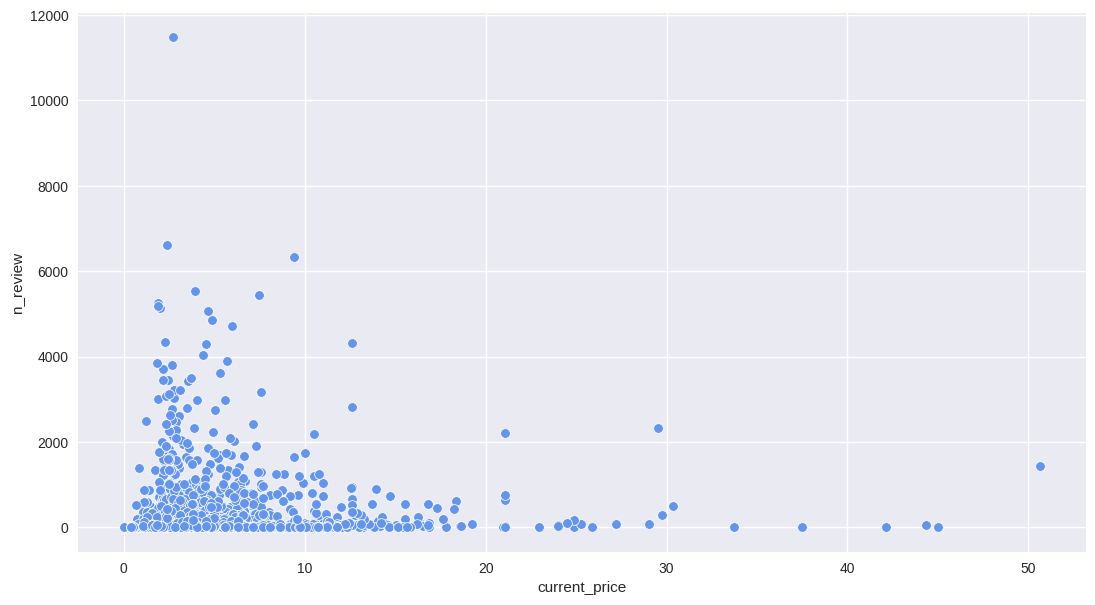

In [ ]:
sns.scatterplot(data=eda_df, x='current_price',y='n_review', color='cornflowerblue');

Hầu hết các cuốn sách có đánh giá lớn đều xoay quanh 0 và 10.

Do đó, chúng ta không thể coi những cuốn sách càng đắt tiền là có càng bài đánh giá hơn.

####More reviewed books have higher average ratings?

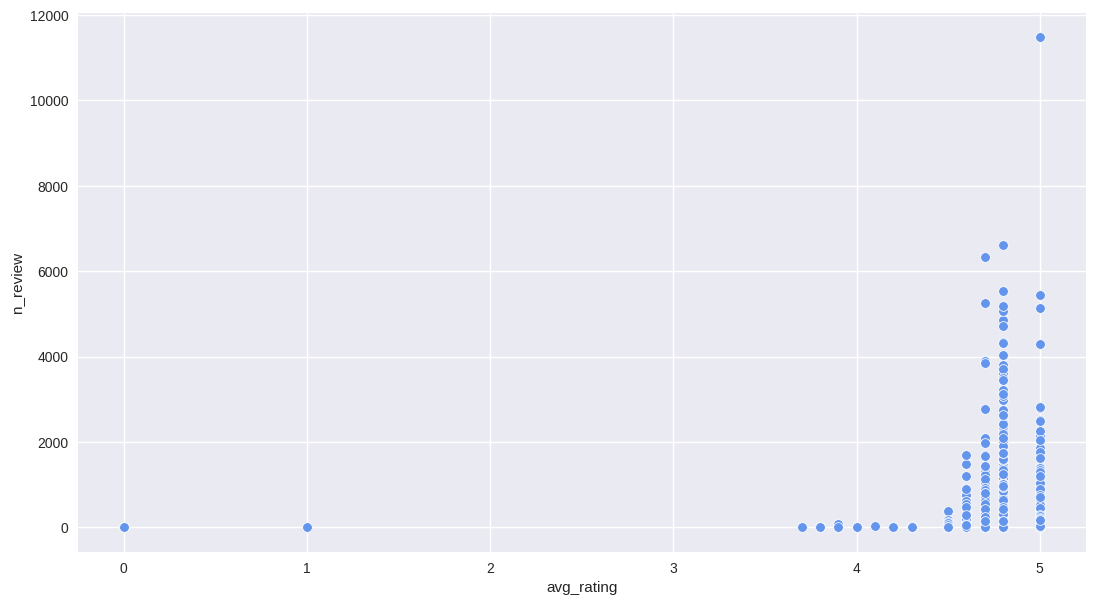

In [ ]:
sns.scatterplot(data=eda_df, x='avg_rating',y='n_review', color='cornflowerblue');

In [ ]:
pd.set_option('display.max_colwidth', True)

larger_3000_reviews_df.sort_values(by="n_review",ascending=False).reset_index(drop=True)[['n_review','avg_rating','title']]

,n_review,avg_rating,title
0,11481,5.0,Cây Cam Ngọt Của Tôi
1,6602,4.8,"Nóng Giận Là Bản Năng , Tĩnh Lặng Là Bản Lĩnh"
2,6325,4.7,Luật Tâm Thức - Giải Mã Ma Trận Vũ Trụ
3,5540,4.8,Tâm Lý Học - Phác Họa Chân Dung Kẻ Phạm Tội
4,5447,5.0,Muôn Kiếp Nhân Sinh 2
5,5255,4.7,Vui Vẻ Không Quạu Nha - Tản Văn
6,5173,4.8,Từ Điển Tiếng “Em”
7,5131,5.0,Nhà Giả Kim (Tái Bản 2020)
8,5075,4.8,Muôn Kiếp Nhân Sinh (Many Lives - Many Times)
9,4863,4.8,"Thiên Tài Bên Trái, Kẻ Điên Bên Phải (Tái Bản)"


In [ ]:
pd.reset_option('display.max_colwidth')

Tất cả các cuốn sách có hơn 3000 đánh giá đều có hơn 4,7 xếp hạng trung bình.

####The more pages, the more expensive?

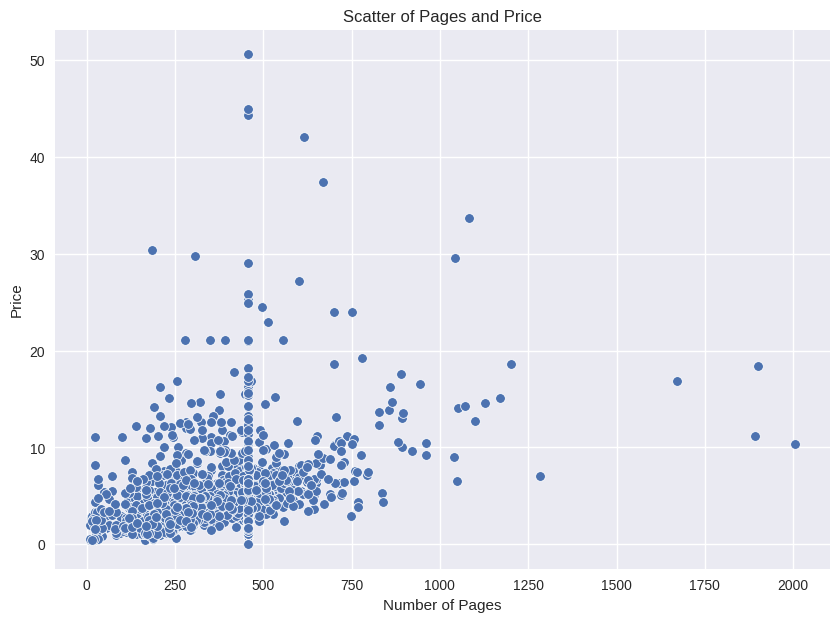

In [ ]:
fig = plt.subplots(figsize=(10, 7))

ax=sns.scatterplot(data=eda_df, x='pages', y='current_price')#, color="",color_continuous_scale='RdBu_r')

plt.xlabel('Number of Pages')
plt.ylabel('Price')
plt.title('Scatter of Pages and Price')
plt.show()

Có một số cuốn sách có trang lớn và giá thấp, và ngược lại.

####What is the largest authors?

The assumption is that the author always in top 5 of:
* Quantity
* Number of Reviews
* Average Rating

In [ ]:
def sort_authors_by_col(col):
    res = eda_df.groupby('authors')[col]\
        .mean()\
        .sort_values(ascending=False)\
        .index.tolist()

    return res

In [ ]:
quantity_lst = sort_authors_by_col("quantity")
n_reviews_lst = sort_authors_by_col("n_review")
avg_rating_lst = sort_authors_by_col("avg_rating")

In [ ]:
def top_k_common_elements(list1, list2, list3, k=10):
    list1, list2, list3 = list1[:k], list2[:k], list3[:k]
    return list(set(list1) & set(list2) & set(list3))

result = top_k_common_elements(quantity_lst, n_reviews_lst, avg_rating_lst, 100)
result

['GEORGE SAMUEL CLASON', 'Jack Canfield & DD.Watkins', 'Thái Phạm']

In the top 100 of the defined-assumption, we found three authors:

* jack Canfield & DD.Watkins
* GEORGE SAMUEL CLASON
* Thái Phạm

In [ ]:
# Jack Canfield & DD.Watkins
eda_df.query('authors == "Jack Canfield & DD.Watkins"')\
        .sort_values(by='quantity', ascending=False)\
        .reset_index(drop=True)\
        .drop(['authors'], axis=1)

,title,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Người Nam Châm (Tái Bản 2019),2.74,1.94,14075,Sách kỹ năng làm việc,1774,5.0,194,Unknown,0.29


In [ ]:
# Thái Phạm
eda_df.query('authors == "Thái Phạm"')\
        .sort_values(by='quantity', ascending=False)\
        .reset_index(drop=True)\
        .drop(['authors'], axis=1)

,title,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Thiết Kế Cuộc Đời Thịnh Vượng - Design a Prosp...,12.62,12.62,15571,Others,2808,5.0,352,Nhà Xuất Bản Thế Giới,0.0
1,101 Lời Khuyên Tài Chính Cá Nhân Từ Thái Phạm,12.62,12.62,381,"Sách tài chính, tiền tệ",52,5.0,408,Nhà Xuất Bản Thế Giới,0.0


In [ ]:
# GEORGE SAMUEL CLASON
eda_df.query('authors == "GEORGE SAMUEL CLASON"')\
        .sort_values(by='quantity', ascending=False)\
        .reset_index(drop=True)\
        .drop(['authors'], axis=1)

,title,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Người Giàu Có Nhất Thành Babylon (Tái Bản 2020),4.14,2.73,12729,Bài học kinh doanh,2134,5.0,216,Nhà Xuất Bản Tổng hợp TP.HCM,0.34


####What is the best seller book?


What is the best seller book?
The assumsion is that the book always in top 5 of:

* Quantity
* Number of Reviews
* Average Rating

In [ ]:
def sort_title_by_col(col):
    # I used a trick here, because we group by title (without duplicated value).
    # The aim is to map with title against.
    res = eda_df.groupby("title")[col].max()\
        .sort_values(ascending=False)\
        .index.tolist()

    return res

In [ ]:
quantity_lst = sort_title_by_col("quantity")
n_reviews_lst = sort_title_by_col("n_review")
avg_rating_lst = sort_title_by_col("avg_rating")

In [ ]:
def top_k_common_elements(list1, list2, list3, k=10):
    list1, list2, list3 = list1[:k], list2[:k], list3[:k]
    return list(set(list1) & set(list2) & set(list3))

result = top_k_common_elements(quantity_lst, n_reviews_lst, avg_rating_lst, 200)
result

['Muôn Kiếp Nhân Sinh 2',
 'Từ Tốt Đến Vĩ Đại (Tái bản 2021)',
 'Muôn Kiếp Nhân Sinh (Bìa Cứng)',
 'Không Sợ Chậm Chỉ Sợ Dừng\xa0',
 'Làm Bạn Với Bầu Trời (Bìa Mềm) (Tặng Kèm Khung Ảnh Số Lượng Có Hạn)',
 'Giải Thích Ngữ Pháp Tiếng Anh (Với Bài Tập Và Đáp Án) (Tái Bản)']

In [ ]:
eda_df.loc[eda_df.title.isin(result)].reset_index(drop=True)

,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Giải Thích Ngữ Pháp Tiếng Anh (Với Bài Tập Và ...,Mai Lan Hương,9.28,6.41,5616,Sách Học Tiếng Anh,1014,5.0,560,Nhà Xuất Bản Đà Nẵng,0.31
1,Không Sợ Chậm Chỉ Sợ Dừng,Vãn Tình,5.44,3.50,13655,Sách nghệ thuật sống đẹp,2802,5.0,364,Nhà Xuất Bản Thế Giới,0.36
2,Từ Tốt Đến Vĩ Đại (Tái bản 2021),Unknown,5.49,3.96,8235,Sách kinh tế học,1119,5.0,484,Nhà Xuất Bản Trẻ,0.28
3,Muôn Kiếp Nhân Sinh (Bìa Cứng),Nguyên Phong,9.62,6.35,7391,Others,1421,5.0,424,Nhà Xuất Bản Tổng hợp TP.HCM,0.34
4,Làm Bạn Với Bầu Trời (Bìa Mềm) (Tặng Kèm Khung...,Nguyễn Nhật Ánh,4.64,3.16,26282,Truyện dài,2043,5.0,220,Unknown,0.32
5,Muôn Kiếp Nhân Sinh 2,Nguyên Phong,11.31,7.46,23606,Others,5447,5.0,540,Nhà Xuất Bản Tổng hợp TP.HCM,0.34


####Correlation between price and category


In [ ]:
plt.rcParams["font.family"] = "DejaVu Sans"  # Hoặc "Arial Unicode MS"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0 - Size: 229
Sách nghệ thuật sống đẹp      58
Sách kỹ năng làm việc         55
Sách Marketing - Bán hàng     40
Sách Làm Cha Mẹ               32
Sách quản trị, lãnh đạo       18
Sách kinh tế học              13
Sách giáo dục                 13
Name: category, dtype: Int64

Cluster 1 - Size: 838
Others                         755
Sách Học Tiếng Anh              41
Sách Chiêm Tinh - Horoscope     14
Lịch Sử Thế Giới                14
Sách Học Tiếng Hoa              14
Name: category, dtype: Int64

Cluster 2 - Size: 281
Truyện ngắn - Tản văn - Tạp Văn    108
Truyện trinh thám                   52
Tác phẩm kinh điển                  38
Văn học thiếu nhi                   21
Truyện kể cho bé                    18
Truyện đam mỹ                       18
Truyện tranh Ehon                   14
Tô màu - Luyện chữ                  12
Name: category, dtype: Int64

Cluster 3 - Size: 159
Kiến thức - Bách khoa    56
Bài học kinh doanh       53
Lĩnh vực khác            31
Light novel         

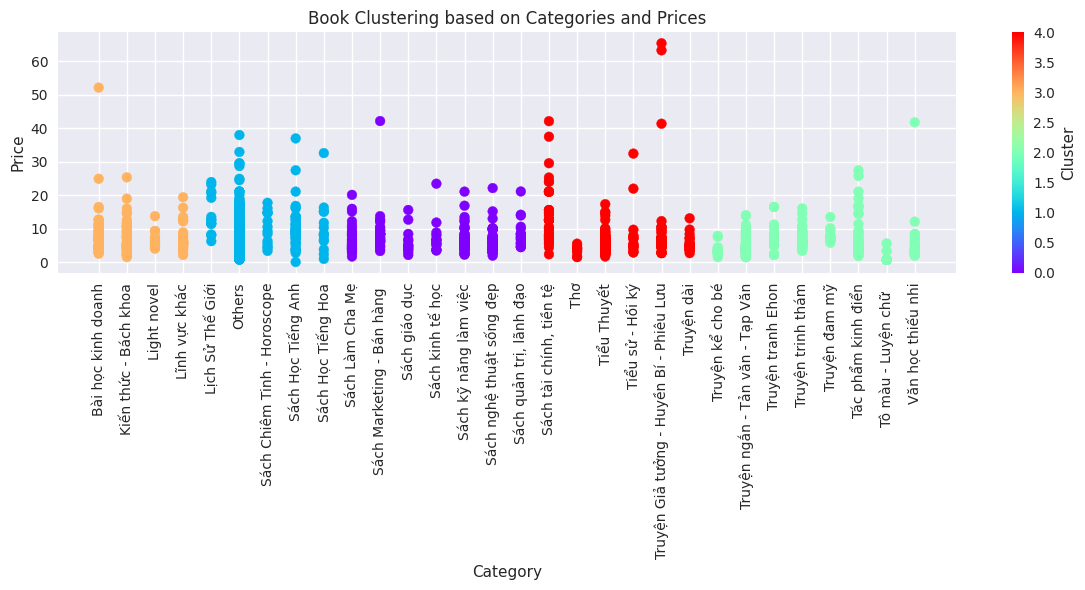

In [ ]:

# Tiền xử lý dữ liệu: chuyển cụm thể loại thành số
encoder = LabelEncoder()
correlation_df = eda_df
correlation_df['CategoryEncoded'] = encoder.fit_transform(correlation_df['category'])

# Sử dụng thuật toán KMeans để phân cụm
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(correlation_df[['CategoryEncoded']])

# Thêm cột phân cụm vào dữ liệu
correlation_df['Cluster'] = kmeans.labels_

# In ra một số thông tin về các cụm
for cluster_id in range(num_clusters):
    cluster_data = correlation_df[correlation_df['Cluster'] == cluster_id]
    print(f"Cluster {cluster_id} - Size: {len(cluster_data)}")
    print(cluster_data['category'].value_counts())
    print()

# Vẽ biểu đồ phân cụm
plt.figure(figsize=(12, 6))
plt.scatter(correlation_df['CategoryEncoded'], correlation_df['original_price'], c=correlation_df['Cluster'], cmap='rainbow')
plt.title('Book Clustering based on Categories and Prices')
plt.xlabel('Category')
plt.ylabel('Price')
plt.xticks(range(len(encoder.classes_)), encoder.classes_, rotation=90)
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


##Remove Outliner

###Price

In [ ]:
# Tính Q1 và Q3
Q1 = data_df['original_price'].quantile(0.25)
Q3 = data_df['original_price'].quantile(0.75)

# Tính IQR
IQR = Q3 - Q1

# Xác định ngưỡng để xác định outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Loại bỏ outlier
data_df = data_df[(data_df['original_price'] >= lower_bound) & (data_df['original_price'] <= upper_bound)]

###Page

In [ ]:
# Tính Q1 và Q3
Q1 = data_df['pages'].quantile(0.25)
Q3 = data_df['pages'].quantile(0.75)

# Tính IQR
IQR = Q3 - Q1

# Xác định ngưỡng để xác định outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Loại bỏ outlier
data_df = data_df[(data_df['pages'] >= lower_bound) & (data_df['pages'] <= upper_bound)]

##Save File

In [ ]:
data_df

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link,discount
0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,4.56,2.73,53075,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...,0.40
2,184466860,Hành Tinh Của Một Kẻ Nghĩ Nhiều,Nguyễn Đoàn Minh Thư,3.63,2.53,7929,Others,780,4.8,184,Nhà Xuất Bản Thế Giới,https://salt.tikicdn.com/ts/product/d7/99/24/1...,0.30
3,73787185,Những Tù Nhân Của Địa Lý,Tim Marshall,8.86,5.32,17896,Lĩnh vực khác,3623,4.8,430,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/8d/96/9e/c...,0.40
4,52789367,Nhà Giả Kim (Tái Bản 2020),Paulo Coelho,3.33,2.00,24668,Tác phẩm kinh điển,5131,5.0,228,Nhà Xuất Bản Hà Nội,https://salt.tikicdn.com/ts/product/45/3b/fc/a...,0.40
5,147920903,Một Thoáng Ta Rực Rỡ Ở Nhân Gian,Unknown,5.70,3.42,10000,Tiểu Thuyết,1636,4.8,304,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/2f/b5/4e/a...,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,192949122,7 Thói Quen Hiệu Quả - The 7 Habits Of Highly ...,Stephen R Covey,10.55,8.07,76,Others,7,5.0,456,Nhà Xuất Bản Tổng hợp TP.HCM,https://salt.tikicdn.com/ts/product/ba/c3/c0/1...,0.24
1792,157579054,Các Vấn Đề Của Triết Học (The Problems Of Phil...,Bertrand Russell,3.59,2.06,147,Others,20,5.0,236,Nhà Xuất Bản Khoa Học Xã Hội,https://salt.tikicdn.com/ts/product/a5/52/7f/3...,0.42
1793,20704715,Để Con Được Chích - Hiểu Hết Về Vắc Xin Và Miễ...,Uyên Bùi,4.56,1.82,931,Sách Làm Cha Mẹ,47,4.6,296,Unknown,https://salt.tikicdn.com/ts/product/05/15/e0/1...,0.60
1794,131144753,Nhà Lãnh Đạo 360 Độ (Tái Bản),John C. Maxwell,7.55,4.54,378,"Sách quản trị, lãnh đạo",33,5.0,436,Nhà Xuất Bản Lao Động,https://salt.tikicdn.com/ts/product/fd/bd/40/8...,0.40


In [ ]:
data_df.to_csv("/content/drive/MyDrive/DataMining/BTL/data/prepared_data_book.csv")